# ABS Annual State Accounts

## Python set-up

In [1]:
# analytic imports
import numpy as np
import pandas as pd
import readabs as ra
import matplotlib.pyplot as plt
from readabs import metacol as mc
import mgplot as mg

#local imports
from abs_helper import (
    get_abs_data,
    get_population,
)

# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999

# display charts within this notebook
SHOW = False
FILE_TYPE = "png"

# abbreviate state names
STATE_MAP = {x: y for x, y in zip(mg.state_names, mg.state_abbrs)}

## Get primary data

In [2]:
abs_dict, meta, source, _ = get_abs_data("5220.0")
meta[mc.table].unique()

array(['5220001_Annual_Gross_State_Product_All_States',
       '5220002_Annual_NSW', '5220003_Annual_VIC', '5220004_Annual_QLD',
       '5220005_Annual_SA', '5220006_Annual_WA', '5220007_Annual_TAS',
       '5220008_Annual_NT', '5220009_Annual_ACT', '5220010_Annual_AUS',
       '5220012_Annual_Household_NSW', '5220013_Annual_Household_VIC',
       '5220014_Annual_Household_QLD', '5220015_Annual_Household_SA',
       '5220016_Annual_Household_WA', '5220017_Annual_Household_TAS',
       '5220018_Annual_Household_NT', '5220019_Annual_Household_ACT',
       '5220020_Annual_Household_AUS', '5220021_NSW', '5220022_VIC',
       '5220023_QLD', '5220024_SA', '5220025_WA', '5220026_TAS',
       '5220027_NT', '5220028_ACT'], dtype=object)

In [3]:
def get_data(table: str, did: str, stype: str) -> tuple[pd.DataFrame, str]:
    "Extract a set of related state columns from the ABS data."

    selector = {
        table: mc.table,
        did: mc.did,
        stype: mc.stype,
    }
    rows = ra.search_abs_meta(
        meta,
        selector
    )
    data = abs_dict[table][rows[mc.id]]
    names = rows[mc.did].str.replace(did, "").str.strip().tolist()
    data.index.name = "Year"
    data.columns = names
    units = rows[mc.unit].iloc[0]

    return data, units

## Plot

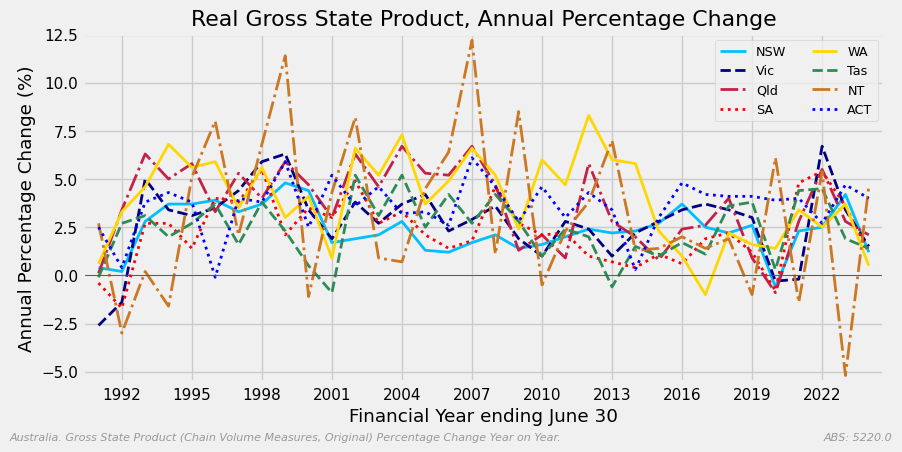

In [4]:
def annual_growth():

    # get the data
    table = '5220001_Annual_Gross_State_Product_All_States'
    did = ";  Gross state product: Chain volume measures - Percentage changes ;"
    stype = "Original"
    data, _units = get_data(table, did, stype)
    data.columns = [STATE_MAP[s] for s in data.columns]


    # plot the data
    mg.line_plot_finalise(
        data,
        title="Real Gross State Product, Annual Percentage Change",
        color=[mg.get_color(x) for x in data.columns],
        xlabel="Financial Year ending June 30",
        ylabel="Annual Percentage Change (%)",
        y0=True,
        rfooter=source,
        lfooter="Australia. " +
                "Gross State Product (Chain Volume Measures, Original) " +
                "Percentage Change Year on Year. ",
        legend={"loc": "best", "ncol": 2, "fontsize": "small"},
        show=True,
    )


annual_growth()

In [5]:
def latest_gsp() -> tuple[pd.DataFrame, str, str, pd.Period]:
    """Get the latest Gross State Product data.
    Returns:
        recent_gsp: pd.DataFrame
            The most recent GSP data for all states.
        units: str
            The units of the GSP data.
        recent_year: str
            The year of the most recent GSP data.
        recent_qtr: pd.Period
            The quarter corresponding to the most recent GSP data.
    """

    table = '5220001_Annual_Gross_State_Product_All_States'
    did = ";  Gross state product: Chain volume measures ;"
    stype = "Original"
    data, gsp_units = get_data(table, did, stype)
    recent_year = data.index.max()
    recent_gsp = data.loc[recent_year]
    recent_qtr = pd.Period(f"{recent_year}-Q2", freq="Q")
    return recent_gsp, gsp_units, recent_year, recent_qtr


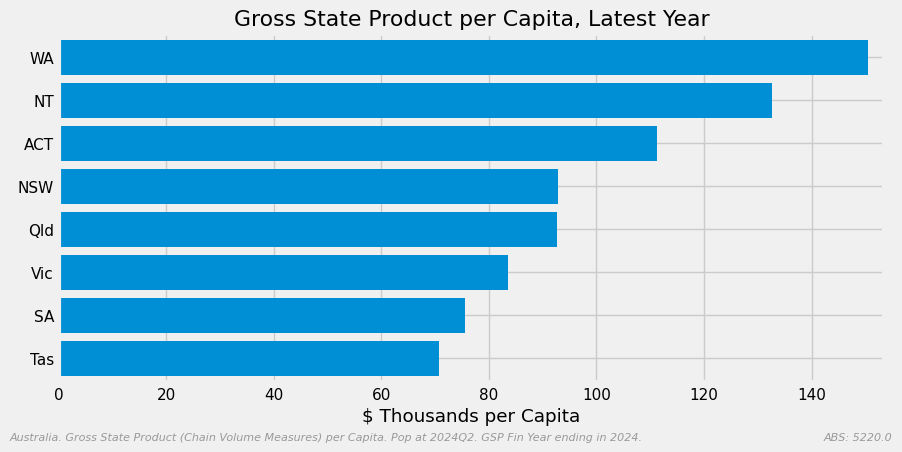

In [6]:
def gsp_per_capita() -> None:
    """Gross State Product per Capita Bar Chart"""

    recent_gsp, gsp_units, recent_year, recent_qtr = latest_gsp()

    # get population data
    state_units = [get_population(state, project=False)[1] for state in mg.state_names]
    state_pops = pd.DataFrame(
        {state: get_population(state, project=False)[0] for state in mg.state_names}
    )
    recent_pop_date  = recent_qtr if recent_qtr in state_pops.index else state_pops.index[-1]
    recent_pop = state_pops.loc[recent_pop_date]

    # plot GSP per capita
    gsp_per_capita, pc_units = ra.recalibrate(recent_gsp.div(recent_pop), gsp_units)
    gsp_per_capita.index = [STATE_MAP[s] for s in gsp_per_capita.index]

    _, ax = plt.subplots()
    gsp_per_capita = gsp_per_capita.sort_values()
    ax.barh(gsp_per_capita.index, gsp_per_capita.values)
    mg.finalise_plot(
        ax,
        title="Gross State Product per Capita, Latest Year",
        xlabel=f"{pc_units} per Capita",
        show=True,
        rfooter=source,
        lfooter="Australia. " + 
                "Gross State Product (Chain Volume Measures) per Capita. " +
                f"Pop at {recent_pop_date}. GSP Fin Year ending in {recent_year}. "
    )


gsp_per_capita()

### GSP per km²

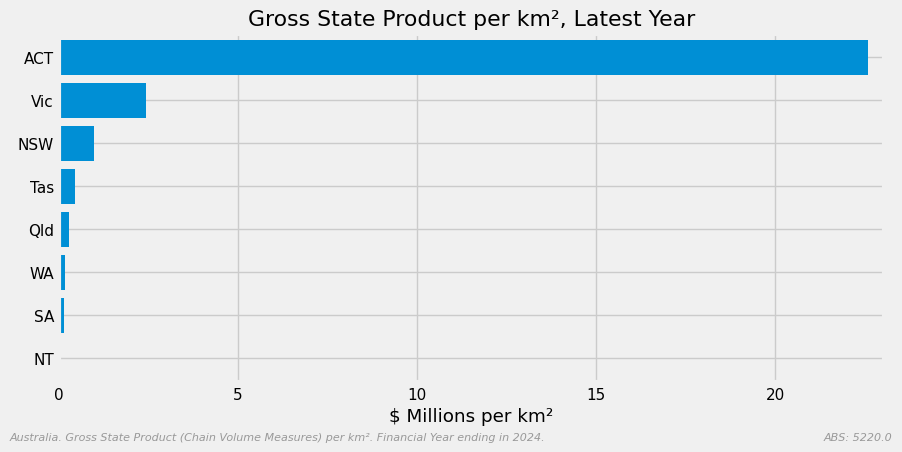

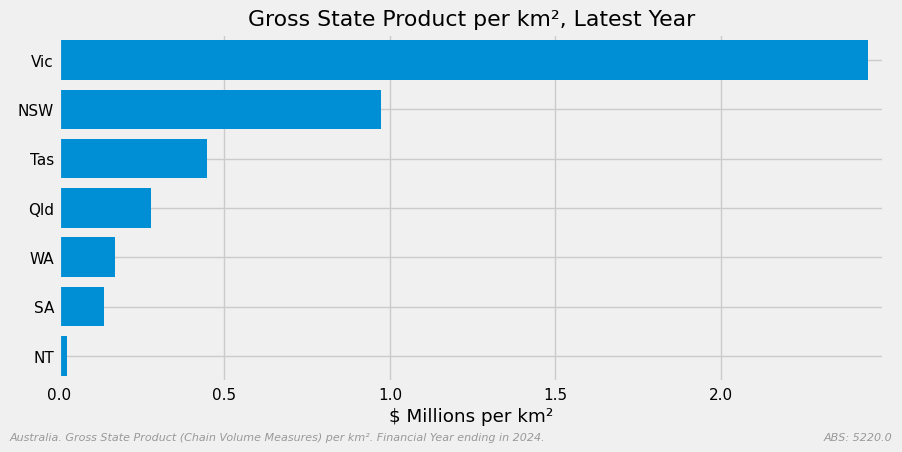

In [7]:
def gsp_per_km2() -> None:
    """Gross State Product per km² Bar Chart"""

    # Gross state product
    recent_gsp, gsp_units, recent_year, recent_qtr = latest_gsp()

    # State Areas
    areas = pd.Series({
        "New South Wales": 809_952,
        "Victoria": 237_657,
        "Queensland": 1_851_736,
        "South Australia": 1_044_353,
        "Western Australia": 2_642_753,
        "Tasmania": 90_758,
        "Northern Territory": 1_420_970,
        "Australian Capital Territory": 2_358,
    })
    gsp_per_area = recent_gsp.div(areas)
    gsp_per_area.index = [STATE_MAP[s] for s in gsp_per_area.index]

    # plot
    for loop in (0, 1):
        gsp_plot, plot_units = ra.recalibrate(gsp_per_area, gsp_units)
        gsp_plot = gsp_plot.sort_values()
        _, ax = plt.subplots()
        ax.barh(gsp_plot.index, gsp_plot.values)
        mg.finalise_plot(
            ax,
            title="Gross State Product per km², Latest Year",
            xlabel=plot_units + " per km²",
            show=True,
            tag=str(loop),
            rfooter=source,
            lfooter="Australia. " + 
                "Gross State Product (Chain Volume Measures) per km². " +
                f"Financial Year ending in {recent_year}. "
        )
        if "ACT" in gsp_per_area.index:
            gsp_per_area = gsp_per_area.drop("ACT")


gsp_per_km2()

## Done

In [8]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda
print("Done")

Last updated: 2025-10-18 13:47:15

Python implementation: CPython
Python version       : 3.13.8
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

readabs   : 0.1.4
mgplot    : 0.2.12
pandas    : 2.3.1
numpy     : 2.3.2
matplotlib: 3.10.5

Watermark: 2.5.0

Done
